In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.tree import DecisionTreeClassifier

In [3]:
df = pd.read_csv('Customer-Churn.csv')

In [5]:
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes


## Data Cleaning

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Contract          7043 non-null   object 
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7043 non-null   object 
 15  Churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

In [16]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(value=0)
df.loc[df['Churn'] == 'Yes', 'Churn'] = 1
df.loc[df['Churn'] == 'No', 'Churn'] = 0
df['Churn'] = pd.to_numeric(df['Churn'])

In [22]:
[print(col, df[col].unique()) for col in df.select_dtypes('object')];

gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']


In [24]:
df.select_dtypes('number').head(2)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
0,0,1,29.85,29.85,0
1,0,34,56.95,1889.50,0


## EDA 

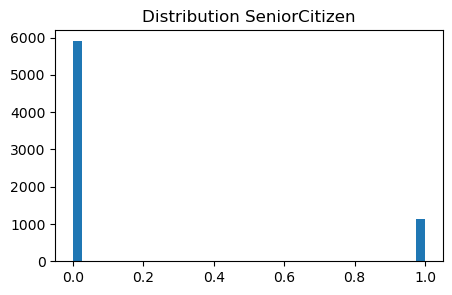

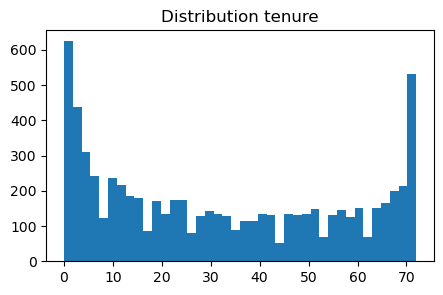

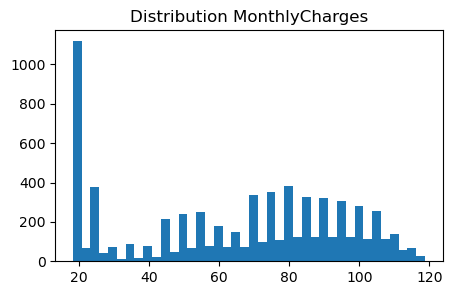

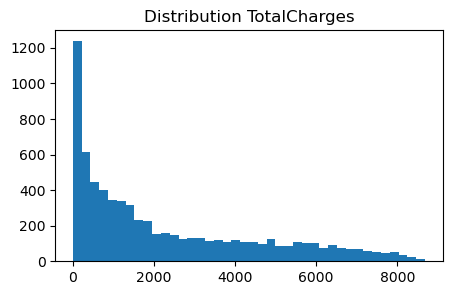

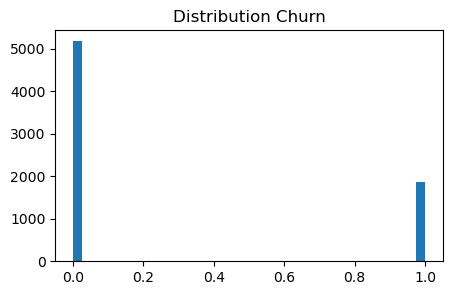

In [37]:
plt.rcParams["figure.figsize"] = (5,3)
for col in df.select_dtypes('number'):
    plt.hist(df[col], bins=40)
    plt.title(f'Distribution {col}')
    plt.show()

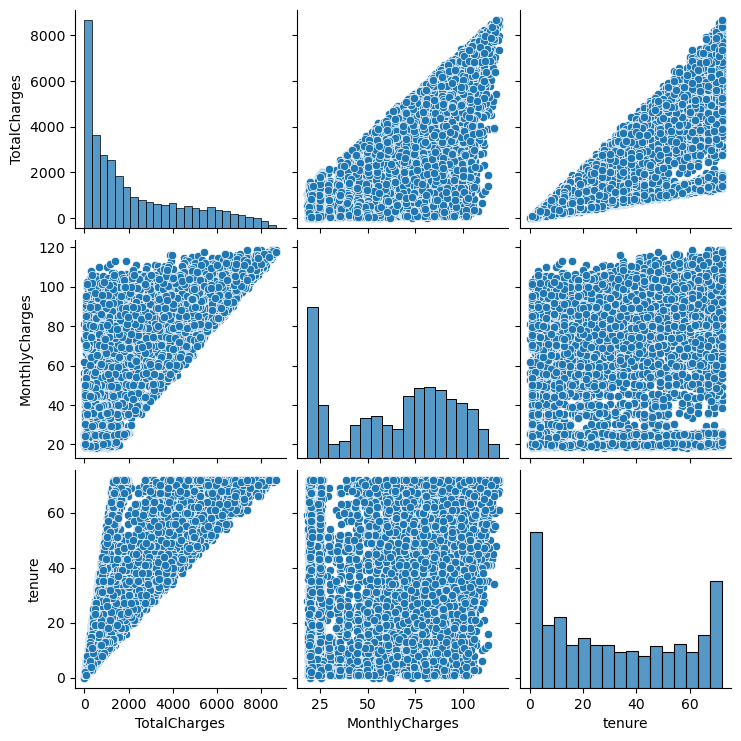

In [43]:
sns.pairplot(df[['TotalCharges', 'MonthlyCharges', 'tenure']])

In [95]:
def custom_pipeline(sampler, model):
    return Pipeline([
        ('scaler',  ColumnTransformer([
            ("numericals", MinMaxScaler(), df.select_dtypes('number').drop('Churn', axis=1).columns),
            ("categoricals", OneHotEncoder(sparse=False), df.select_dtypes('object').columns)
        ])),
        ('sampler', sampler),
        ('model', model)
    ])

In [104]:
def show_confusion_matrix(y_pred, y_test, classes, title):
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(colorbar=False)
    disp.ax_.set_title(title)
    plt.show()

In [96]:
y = df['Churn']
X = df.drop('Churn', axis=1)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)

## Model Comparisson

### Use SMOTE with Logistic Regression and Decision Tree Classifier

LogisticRegression - SMOTE
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1035
           1       0.52      0.78      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



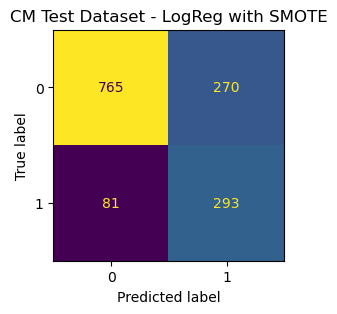

In [107]:
clf1 = custom_pipeline(SMOTE(), LogisticRegression())
clf1.fit(X_train, y_train)

y_pred_clf1 = clf1.predict(X_test)
print('LogisticRegression - SMOTE')
print(classification_report(y_test, y_pred_clf1))
show_confusion_matrix(y_pred_clf1, y_test, clf1[2].classes_, 'CM Test Dataset - LogReg with SMOTE')

Decision Tree Classifier - SMOTE
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1035
           1       0.47      0.56      0.51       374

    accuracy                           0.72      1409
   macro avg       0.65      0.67      0.66      1409
weighted avg       0.73      0.72      0.72      1409



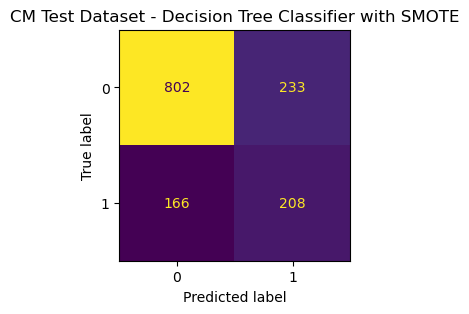

In [118]:
clf2 = custom_pipeline(SMOTE(), DecisionTreeClassifier())
clf2.fit(X_train, y_train)

y_pred_clf2 = clf2.predict(X_test)
print('Decision Tree Classifier - SMOTE')
print(classification_report(y_test, y_pred_clf2))
show_confusion_matrix(y_pred_clf2, y_test, clf2[2].classes_, 
                      'CM Test Dataset - Decision Tree Classifier with SMOTE')

In [124]:
def create_comparisson_table():
    return pd.DataFrame([], columns=['model', 'sampler', 'f1_score', 'yes_f1', \
                                          'yes_precision', 'yes_recall', 'no_f1', 'no_precision', 'no_recall'])


def add_scores_to_overall_results(df_results, scores_test, sampler, estimator):
    df_results.loc[df_results.shape[0]] = [get_class_name(estimator), get_class_name(sampler) if sampler else None,
                                          scores_test.at["accuracy","f1-score"], scores_test.at["1","f1-score"],
                                          scores_test.at["1","precision"], scores_test.at["1","recall"],
                                          scores_test.at["0","f1-score"], scores_test.at["0","precision"],
                                          scores_test.at["0","recall"]]
    
def get_class_name(cl):
    return cl.__class__.__name__

In [125]:
models_smote = create_comparisson_table()

In [126]:
add_scores_to_overall_results(models_smote, 
                              pd.DataFrame(classification_report(y_test, y_pred_clf1, output_dict=True)).T, 
                              clf1[1], 
                              clf1[2])

add_scores_to_overall_results(models_smote, 
                              pd.DataFrame(classification_report(y_test, y_pred_clf2, output_dict=True)).T, 
                              clf2[1], 
                              clf2[2])

In [127]:
model_comparisson

,model,sampler,f1_score,yes_f1,yes_precision,yes_recall,no_f1,no_precision,no_recall
0,LogisticRegression,SMOTE,0.750887,0.625400,0.520426,0.783422,0.813397,0.904255,0.739130
1,DecisionTreeClassifier,SMOTE,0.716820,0.510429,0.471655,0.556150,0.800799,0.828512,0.774879


### Use TomekLinks with Logistic Regression and Decision Tree Classifier

LogisticRegression - TomekLinks
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1035
           1       0.61      0.62      0.62       374

    accuracy                           0.79      1409
   macro avg       0.74      0.74      0.74      1409
weighted avg       0.80      0.79      0.79      1409



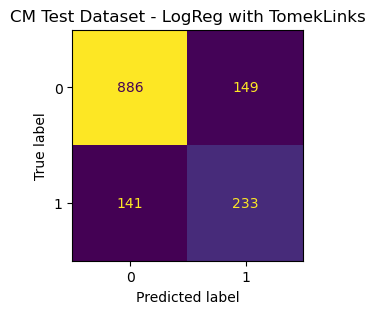

In [129]:
clf3 = custom_pipeline(TomekLinks(), LogisticRegression())
clf3.fit(X_train, y_train)

y_pred_clf3 = clf3.predict(X_test)
print('LogisticRegression - TomekLinks')
print(classification_report(y_test, y_pred_clf3))
show_confusion_matrix(y_pred_clf3, y_test, clf3[2].classes_, 'CM Test Dataset - LogReg with TomekLinks')

Decision Tree Classifier - TomekLinks
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      1035
           1       0.51      0.60      0.55       374

    accuracy                           0.74      1409
   macro avg       0.68      0.69      0.68      1409
weighted avg       0.76      0.74      0.75      1409



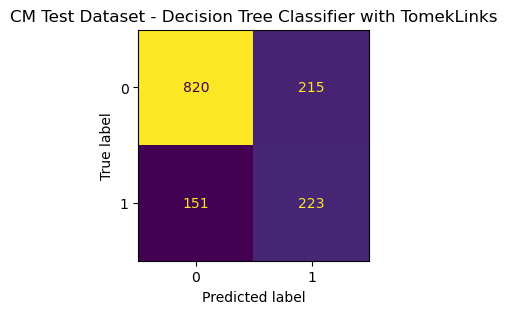

In [128]:
clf4 = custom_pipeline(TomekLinks(), DecisionTreeClassifier())
clf4.fit(X_train, y_train)

y_pred_clf4 = clf4.predict(X_test)
print('Decision Tree Classifier - TomekLinks')
print(classification_report(y_test, y_pred_clf4))
show_confusion_matrix(y_pred_clf4, y_test, clf4[2].classes_, 
                      'CM Test Dataset - Decision Tree Classifier with TomekLinks')

In [130]:
models_tl = create_comparisson_table()
add_scores_to_overall_results(models_tl, 
                              pd.DataFrame(classification_report(y_test, y_pred_clf3, output_dict=True)).T, 
                              clf3[1], 
                              clf3[2])

add_scores_to_overall_results(models_tl, 
                              pd.DataFrame(classification_report(y_test, y_pred_clf4, output_dict=True)).T, 
                              clf4[1], 
                              clf4[2])

In [131]:
models_tl

,model,sampler,f1_score,yes_f1,yes_precision,yes_recall,no_f1,no_precision,no_recall
0,LogisticRegression,TomekLinks,0.794180,0.616402,0.609948,0.622995,0.859360,0.862707,0.856039
1,DecisionTreeClassifier,TomekLinks,0.740241,0.549261,0.509132,0.596257,0.817547,0.844490,0.792271
